# 1.0 Introduction

# 2.0 Requirements and Imports

## 2.1 Requirements

## 2.2 Imports

In [1]:
import os
import re
import bs4
import time
import requests
import pandas as pd
import numpy as np
from os import listdir
from datetime import date
from bs4 import BeautifulSoup  
from os.path import isfile, join

# --- selenium libraries
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service

# language detector
from langdetect import detect
from langdetect import detect_langs

# Wordcloud visualization
import seaborn as sns
import itertools
import collections
from PIL import Image
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

# nltk
import nltk
import nltk.corpus
from nltk import word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, Tree
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')

# sklearn
from sklearn import metrics
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.datasets import fetch_20newsgroups
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score,StratifiedKFold

# Handle warnings
import warnings
warnings.filterwarnings('ignore')




[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sergeyjuchenko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sergeyjuchenko/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# 3.0 Data Acquision


## 3.1 Resources


### 3.1.1 Medium


In [2]:
#chromedriver.exe for windows users!

In [3]:
def get_infinity_page_html_data(chromedriver_path="./chromedriver.exe", scroll_number=1, sleep_time=3):
    # Create selenium driver
    s = Service(chromedriver_path)
    driver = webdriver.Chrome(service=s)    
    driver.get(url)
    
    for i in range(1,scroll_number):
        print(f"scroll_number: {i}")
        driver.execute_script("window.scrollTo(1,50000)")
        time.sleep(sleep_time)
    html_data = driver.page_source
    driver.close()
    
    return html_data

In [4]:
def extract_medium_articles_from_HTML_data(html_data):
    # Extract articles from HTML data 
    soup = BeautifulSoup(html_data, 'html.parser')    
    articles = soup.find_all("article")
    print(f"Number of articles: {len(articles)}")
    
    return articles

In [5]:
def create_df_from_articles(articles,category):    
    # Create a lists for df
    categories = []
    headers = []
    contents = []
    for article in articles:
        headers.append(article.find("h2").get_text()) 
        categories.append(category)
        
        if category == "politics" or category == "food":
            content = article.find("p", {"class": lambda L: L and L.startswith('lj b do dp')})        
        if category == "sports" or category == "technology" or category == "weather":
            content = article.find("p", {"class": lambda L: L and L.startswith('lf b do dp')})
        if category == "entertainment":
            content = article.find("p", {"class": lambda L: L and L.startswith('lg b do dp')})
        if category == "business" or category == "science":
            content = article.find("p", {"class": lambda L: L and L.startswith('li b do dp')})
        
        if content is not None:
            contents.append(content.get_text())
        else:
            contents.append(content)        
        
    return pd.DataFrame(
        {"category": categories,  
         "header": headers,
         "content": contents})

In [6]:
categories = ["technology", "politics", "sports", "entertainment", "weather", "science", "business", "food"]

for category in categories:     
    url = f"https://medium.com/tag/{category}"
    html_data = get_infinity_page_html_data(scroll_number=10)
    articles = extract_medium_articles_from_HTML_data(html_data)
    df = create_df_from_articles(articles, category)
    print(df.shape)
    
    df.to_csv(f"./csv_files/medium_{category}_{date.today()}.csv") 

### 3.1.2 Hubpages

In [7]:
def get_page_html_data_with_see_more_option(url, chromedriver_path="./chromedriver.exe", numbers_of_see_more_clicks=1, sleep_time=3):
    # Create selenium driver
    service = Service(chromedriver_path)
    driver = webdriver.Chrome(service=service)    
    driver.get(url)
    driver.maximize_window()

    for i in range(1,numbers_of_see_more_clicks+1):                
        button_xpath = "//button[@class='m-footer-loader--button m-component-footer--loader m-button']"                
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(sleep_time)
        print(f"Numbers of clicks: {i}")
        driver.find_element(by=By.XPATH, value=button_xpath).click()                    
        time.sleep(sleep_time)
        
    html_data = driver.page_source
    driver.close()
    
    return html_data

In [8]:
def extract_hubpages_articles_from_HTML_data(html_data):        
    # Extract articles from HTML data 
    soup = BeautifulSoup(html_data, 'html.parser')    
    articles = soup.find_all("div", {"class": "m-card--content"})          
    
    return articles

In [9]:
def create_df_from_articles(articles, category):    
    # Create a lists for df
    categories = []
    headers = []
    contents= []

    for article in articles:
        categories.append(category)
        headers.append(article.find("h2").get_text())
        content = article.find("p", {"class": "m-card--body m-ellipsis--text"})
        if content is not None:
            contents.append(content.get_text())            
        else:
            contents.append(content)                
        
    return pd.DataFrame(
        {"category": categories,  
         "header": headers, 
         "contents": contents})

In [10]:
#"science", "weather" - doesnt exists
categories = ["politics", "sports", "food", "entertainment", "business", "technology"]
categories = ["entertainment", "business", "technology"]
for category in categories: 
    url = f"https://discover.hubpages.com/{category}/"
    html_data = get_page_html_data_with_see_more_option(url, numbers_of_see_more_clicks=10)
    articles = extract_hubpages_articles_from_HTML_data(html_data)
    df = create_df_from_articles(articles, category)    
    df.to_csv(f"./csv_files/hubpages_{category}_{date.today()}.csv")
    print(df.shape)    

### 3.1.3 Newsbreak

In [11]:
def get_infinity_page_html_data(chromedriver_path="./chromedriver.exe", scroll_number=1, sleep_time=3):
    # Create selenium driver
    service = Service(chromedriver_path)
    driver = webdriver.Chrome(service=service)    
    driver.get(url)
    
    for i in range(1,scroll_number+1):
        print(f"scroll_number: {i}")
        driver.execute_script("window.scrollTo(1,50000)")
        time.sleep(sleep_time)
    html_data = driver.page_source
    driver.close()
    
    return html_data

In [12]:
def extract_newsbreak_articles_from_HTML_data(html_data):
    # Extract articles from HTML data 
    soup = BeautifulSoup(html_data, 'html.parser')    
    articles = soup.find_all("article")
    print(f"Number of articles: {len(articles)}")        
    
    return articles

In [13]:
def create_df_from_articles(articles,category):    
    # Create a lists for df
    categories = []
    headers = []
    contents= []
        
    for article in articles:            
        categories.append(category)        
        headers.append(article.find("a", {"class": lambda L: L and L.startswith('ContentCardBody_title')}).get_text())                           
        contents.append(article.find("div", {"class": lambda L: L and L.startswith('ContentCardBody_summary')}).get_text())    
    
    return pd.DataFrame(
        {"categories": categories,  
         "headers": headers, 
         "contents": contents})

In [14]:
# "food" - doesnt exists
categories = ["technology","politics", "sports", "science", "entertainment", "business", 'weather']
for category in categories: 
    url = f"https://www.newsbreak.com/channels/{category}"    
    html_data = get_infinity_page_html_data(scroll_number=10)
    articles = extract_newsbreak_articles_from_HTML_data(html_data)
    df = create_df_from_articles(articles,category)
    df.to_csv(f"./csv_files/newsbreak_{category}_{date.today()}.csv")
    print(df.shape)
    print()

### 3.1.4 Weather.com

In [15]:
def extract_articles_HTML(url):
    request = requests.get(url)
    return BeautifulSoup(request.content, 'html.parser')
    

In [16]:
def create_weather_news_df(url,page):
    header = []
    content = []
    category = []
    for i in range(page,page+1):
        time.sleep(3)
        try:
            url = url+f"{i}"
            soup = extract_articles_HTML(url)


            main_content = soup.find("div",{"id":lambda L: L and L.startswith('WxuCollectionMediaList-main')})
            li_lst = main_content.find_all("li")
            print(f"page number: {i}")            
            for li in li_lst:
                header.append(li.find("div",
                                       {"class":lambda L: L and L.startswith('CollectionMediaList--title')}).get_text())
                content.append(li.find("div",
                                       {"class":lambda L: L and L.startswith('CollectionMediaList--caption')}).get_text())
                category.append("weather")
            
        except:
            print(f"error in page {i}")
    return pd.DataFrame({"category":category, "header":header, "content":content})


In [17]:
df = create_weather_news_df('https://weather.com/news?pg=',1)
for i in range(2,201):
    df = df.append(create_weather_news_df('https://weather.com/news?pg=',i))
    time.sleep(4)
    print(df.shape)
df.to_csv(f"./csv_files/weather_com_{date.today()}.csv")

### 3.1.5 ScienceNews

In [18]:
def create_science_news_df(url,page):
    header = []
    content = []
    category = []

    for i in range (page,page+1):
        time.sleep(3)
        try:
            print(f"page number: {i}")
            url = url + f'{i}'
            soup = extract_articles_HTML(url)

            main_content = soup.find_all("ol")[0]
            li_lst = main_content.find_all("li")

            for li in li_lst:
                category.append("science")
                header.append(li.find("h3").get_text().strip())
                content.append(li.find("p").get_text().strip())


        except:
            print(f"error in page {i}")


    return pd.DataFrame({"category":category, "header":header, "content":content})

In [19]:
df = create_science_news_df('https://www.sciencenews.org/topic/science-society/page/',1)
for i in range(2,81):
    df = df.append(create_science_news_df('https://www.sciencenews.org/topic/science-society/page/',i))
    time.sleep(4)
    print(df.shape)

In [20]:
df.to_csv(f"./csv_files/science_news_{date.today()}.csv")

### 3.1.5 Food52

In [21]:
def create_food_news_df(url,page):
    header = []
    content = []
    category = []

    for i in range (page,page+1):
        time.sleep(3)
        try:
            print(f"page number: {i}")
            url = url + f'{i}'
            soup = extract_articles_HTML(url)

            content_lst = soup.find_all("div",{"class":"tag-post__body"})
            for item in content_lst:
                category.append("food")
                header.append(item.find("h3").get_text().strip())
                content.append(item.find("p").get_text().strip())

        except:
            print(f"error in page {i}")


    return pd.DataFrame({"category":category, "header":header, "content":content})

In [22]:
df = create_food_news_df('https://food52.com/tags/food-news?page=',1)
for i in range(2,45):
    df = df.append(create_food_news_df('https://food52.com/tags/food-news?page=',i))
    time.sleep(4)
    print(df.shape)

In [23]:
df.to_csv(f"./csv_files/food52_news_{date.today()}.csv")

## 3.2 Data Acquision Results


In [24]:
#create a list of all file names
file_names_list = [f for f in listdir('./csv_files/') if isfile(join('./csv_files/', f))]

In [25]:
temp_df = pd.read_csv(f'./csv_files/{file_names_list[0]}')
temp_df.columns = ['Unnamed: 0', 'category', 'header', 'content']
merged_df = temp_df.copy()
print("before:",merged_df.shape)

for i in range(1,len(file_names_list)):
    temp_df = pd.read_csv(f'./csv_files/{file_names_list[i]}')
    #change in each df to the same column names
    temp_df.columns = ['Unnamed: 0', 'category', 'header', 'content']
    merged_df = merged_df.append(temp_df)
    
print("after:",merged_df.shape)    

before: (59, 4)
after: (31607, 4)


In [27]:
merged_df.to_csv('merged_csv.csv')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31607 entries, 0 to 549
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  31607 non-null  int64 
 1   category    31607 non-null  object
 2   header      31607 non-null  object
 3   content     26464 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


# 4.0 Data Cleaning


In this notebook we present our research about our data.  
There are two types of cells:
1. A cell that presents research and insights about the data information.
2. A cell that changes the `df` according to the specific insight.

In [28]:
df = pd.read_csv("./merged_csv.csv")

## 4.1 Remove Unnecessary Columns


In [30]:
print(df.shape)
df.head()

(31607, 5)


,Unnamed: 0,Unnamed: 0.1,category,header,content
0,0,0,science,10 Facts You Probably Didn’t Know About Sir Is...,NaN
1,1,1,science,What Your Poo Says About You,NaN
2,2,2,science,Why Psychology Isn’t Science: Let’s Talk About...,NaN
3,3,3,science,Three Unsung Heroes from Our Cosmic Past,NaN
4,4,4,science,Inventions That Were Inspired By Love,NaN


In the df above we have two unnecessary columns:

Unnamed: 0
Unnamed: 0.1 Let's drop these two columns.

In [31]:
# Romove df columns
df.drop(columns="Unnamed: 0", axis=1, inplace=True)
df.drop(columns="Unnamed: 0.1", axis=1, inplace=True)

In [33]:
df

,category,header,content
0,science,10 Facts You Probably Didn’t Know About Sir Is...,NaN
1,science,What Your Poo Says About You,NaN
2,science,Why Psychology Isn’t Science: Let’s Talk About...,NaN
3,science,Three Unsung Heroes from Our Cosmic Past,NaN
4,science,Inventions That Were Inspired By Love,NaN
...,...,...,...
31602,food,Classic Tater Tot Casserole with Green Beans,This is one of my favorite childhood recipe's....
31603,food,Stews of South India,Know about different stews present in South In...
31604,food,Biscuits from Self Rising Flour,Biscuits are a learning experience. Best buy e...
31605,food,Streusel Topping for Banana Bread for Example,Banana bread topping is added just before you ...


## 4.2 Remove Null Objects


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31607 entries, 0 to 31606
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  31607 non-null  object
 1   header    31607 non-null  object
 2   content   26464 non-null  object
dtypes: object(3)
memory usage: 740.9+ KB


In [36]:
# Remove null objects
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26464 entries, 59 to 31606
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  26464 non-null  object
 1   header    26464 non-null  object
 2   content   26464 non-null  object
dtypes: object(3)
memory usage: 827.0+ KB


## 4.2 Remove Duplicate Rows


In [38]:
# Prune duplicate rows
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15413 entries, 59 to 31606
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  15413 non-null  object
 1   header    15413 non-null  object
 2   content   15413 non-null  object
dtypes: object(3)
memory usage: 481.7+ KB


In [39]:
clean_df = df.copy()
clean_df.reset_index(inplace=True)
clean_df.to_csv("clean_df.csv")


# 5.0 EDA


## 5.1 Merged header and content

In [47]:
df = clean_df.copy()

df["merged_text"] = df["header"] + " " + df["content"]
df.drop(columns="header", axis=1, inplace=True)
df.drop(columns="content", axis=1, inplace=True)
df.head()

,index,category,merged_text
0,59,weather,Japan Earthquake: JMA Issues Warning for More ...
1,60,weather,15 things you may not know about earthquakes E...
2,61,weather,'Substantial weather pattern change' bringing ...
3,62,weather,Tropics watch: Forecasters watching one tropic...
4,63,weather,Hundreds of thousands evacuated in China after...


In [48]:
df.drop(columns="index", axis=1, inplace=True)
df.head()

,category,merged_text
0,weather,Japan Earthquake: JMA Issues Warning for More ...
1,weather,15 things you may not know about earthquakes E...
2,weather,'Substantial weather pattern change' bringing ...
3,weather,Tropics watch: Forecasters watching one tropic...
4,weather,Hundreds of thousands evacuated in China after...


## 5.2 Visualization Vol.1

### 5.2.1 Pie Chart

In [49]:
def show_pie_chart(df):
    count_of_categories_articles = df['category'].value_counts(sort=False).to_list()
    categories = df['category'].unique()


    plt.pie(count_of_categories_articles, 
            labels = categories,
            autopct = "%1.1f%%",
            explode = [0.05 for _ in categories])

    plt.show()

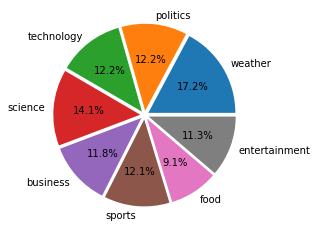

In [50]:
show_pie_chart(df)

### 5.2.2 WordCloud

In [51]:
def wordcloud_draw(dataset, mask=None, color = 'white'):
    if mask is not None:        
        mask = os.path.join(os.getcwd(), mask)
        print(mask)
        mask = np.array(Image.open(f'{mask}',mode='r'))
    
    # Before tokenize
    if isinstance(dataset.iloc[0], str):
        words = ' '.join(dataset)
        cleaned_word = ' '.join([word for word in words.split()])        
        
#     # After tokeniz        
#     elif isinstance(dataset.iloc[0], list):        
#         words = dataset.sum()
#         cleaned_word = ' '.join(words)        
        
    wordcloud = WordCloud(background_color = color,
                          mask = mask,
                          width = 2500, 
                          height = 2500,
                          contour_width=2,).generate(cleaned_word)

    plt.figure(1, figsize = (10,7))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [52]:
## Vizualization word cloud
def show_word_cloud(df):
    category_series_words = {}

    for category in set(df["category"]):
        category_words = df[df["category"] == category]["merged_text"]
        category_series_words[category] = category_words

    for category, series_words in category_series_words.items():        
        wordcloud_draw(series_words, f"png/{category}.png", 'white')

/Users/sergeyjuchenko/Desktop/HIT.DataScience.FinalProject-main/png/entertainment.png


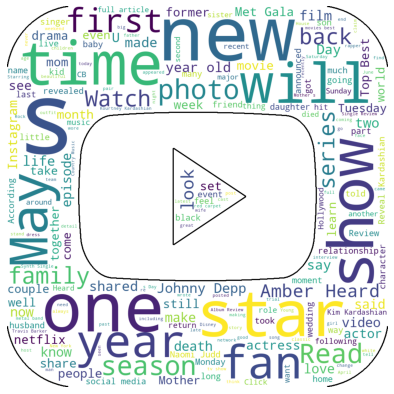

/Users/sergeyjuchenko/Desktop/HIT.DataScience.FinalProject-main/png/weather.png


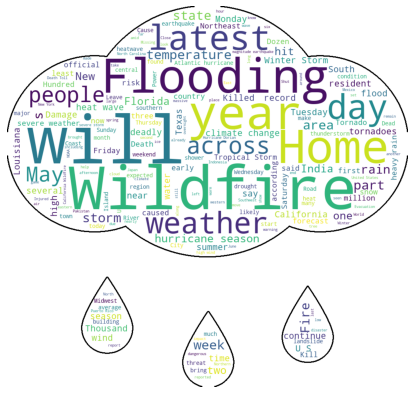

/Users/sergeyjuchenko/Desktop/HIT.DataScience.FinalProject-main/png/business.png


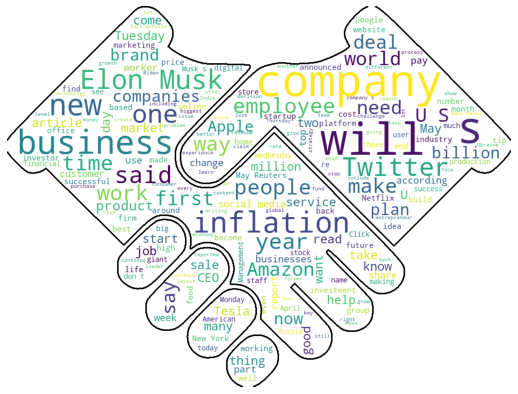

/Users/sergeyjuchenko/Desktop/HIT.DataScience.FinalProject-main/png/politics.png


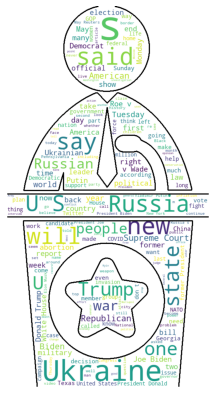

/Users/sergeyjuchenko/Desktop/HIT.DataScience.FinalProject-main/png/sports.png


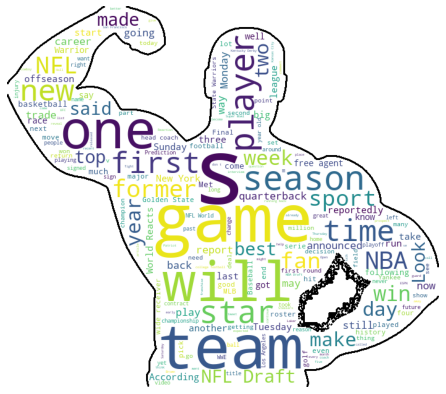

/Users/sergeyjuchenko/Desktop/HIT.DataScience.FinalProject-main/png/food.png


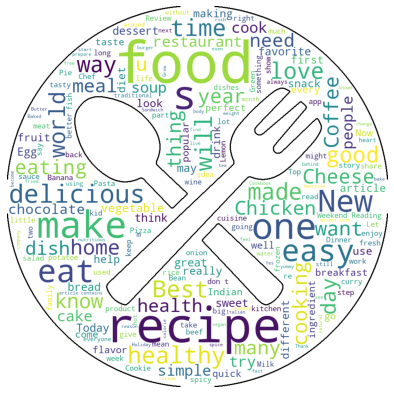

/Users/sergeyjuchenko/Desktop/HIT.DataScience.FinalProject-main/png/technology.png


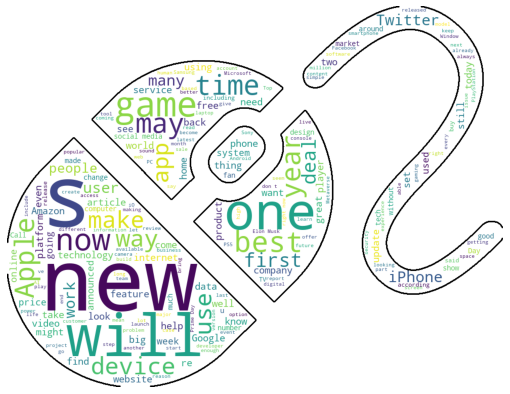

/Users/sergeyjuchenko/Desktop/HIT.DataScience.FinalProject-main/png/science.png


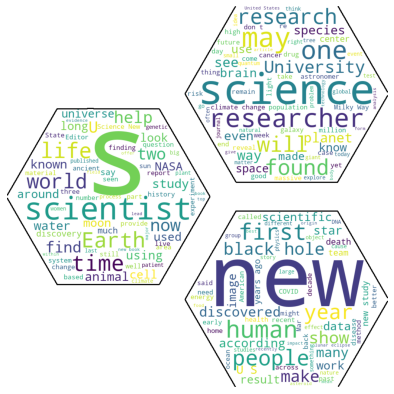

In [53]:
show_word_cloud(df)

### 5.2.3 Top 10 words

In [54]:
def show_top_10_words(df):
    tmp_df = df.copy()
    if isinstance(tmp_df['merged_text'].iloc[0], str):
        tmp_df['merged_text'] = tmp_df['merged_text'].apply(word_tokenize)
        
    for category in set(tmp_df["category"]):        
        category_words = tmp_df[tmp_df["category"] == category]["merged_text"]

        filtered_words = list(itertools.chain.from_iterable(category_words))        
        counted_words = collections.Counter(filtered_words)

    
        words = []
        counts = []
        for letter, count in counted_words.most_common(10):
            words.append(letter)
            counts.append(count)

        colors = cm.rainbow(np.linspace(0, 1, 10))
        rcParams['figure.figsize'] = 20, 10

        plt.title(f'Top words in the {category} articles')
        plt.xlabel('Count')
        plt.ylabel('Words')
        plt.barh(words, counts, color=colors)
        plt.show()

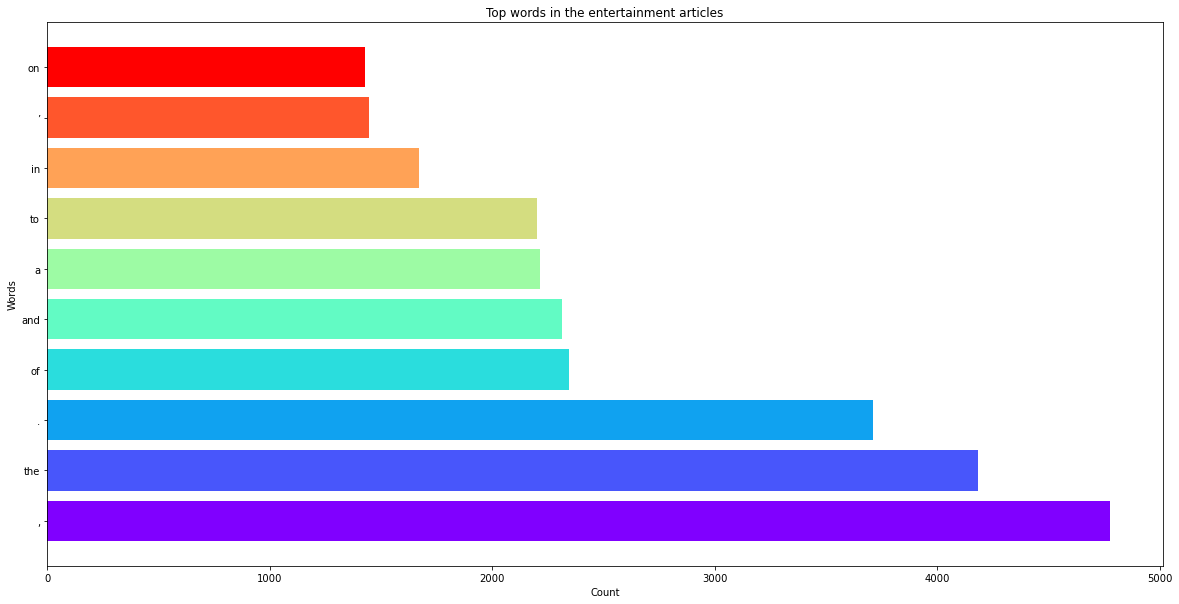

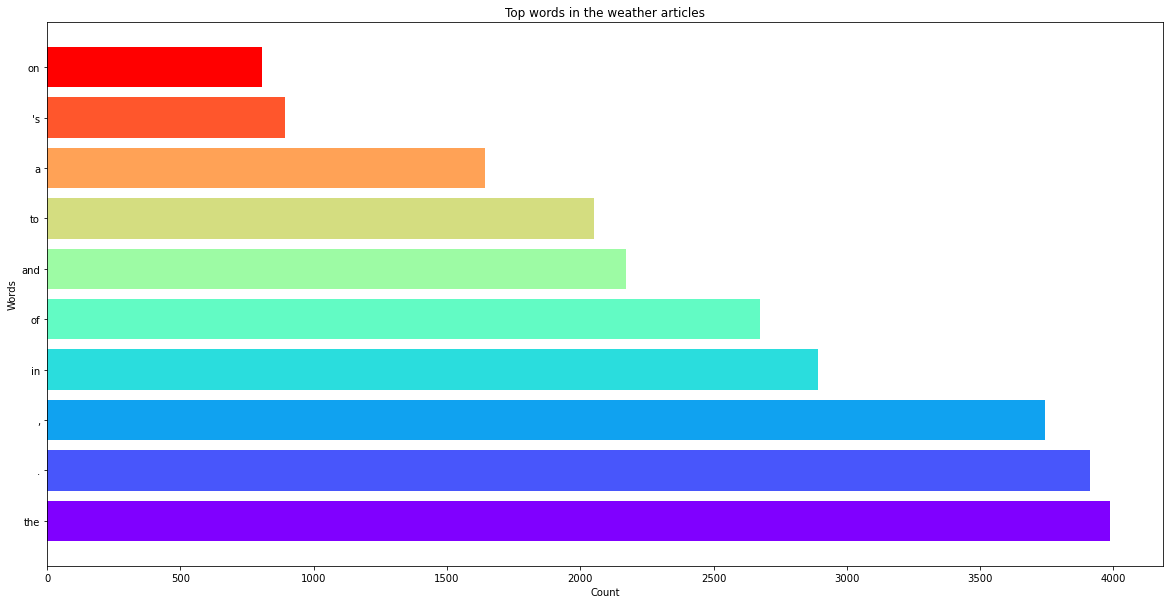

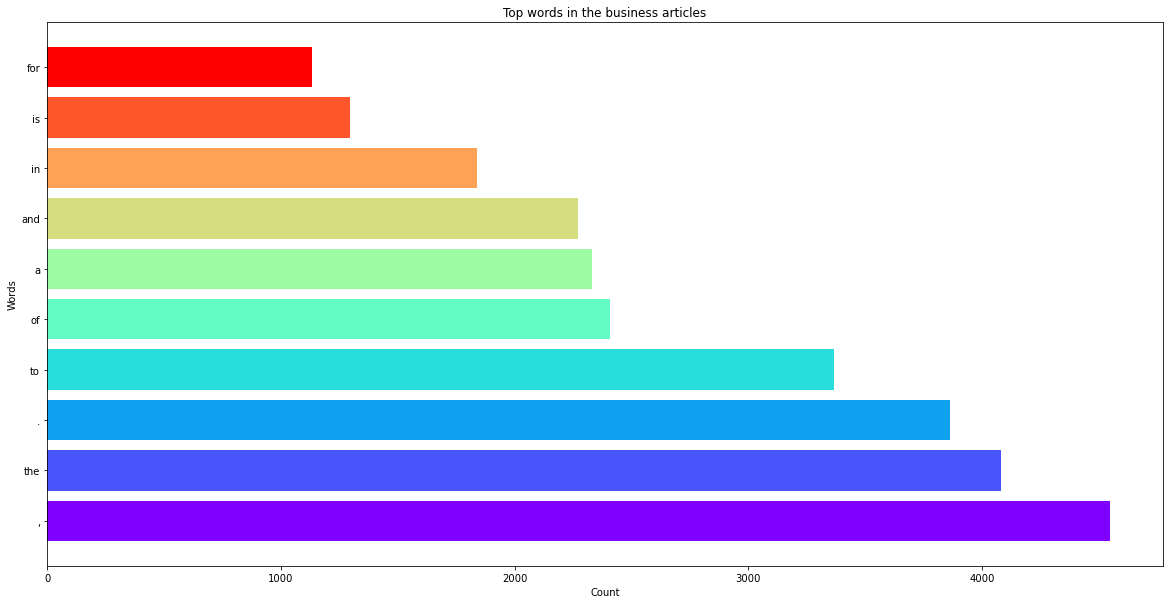

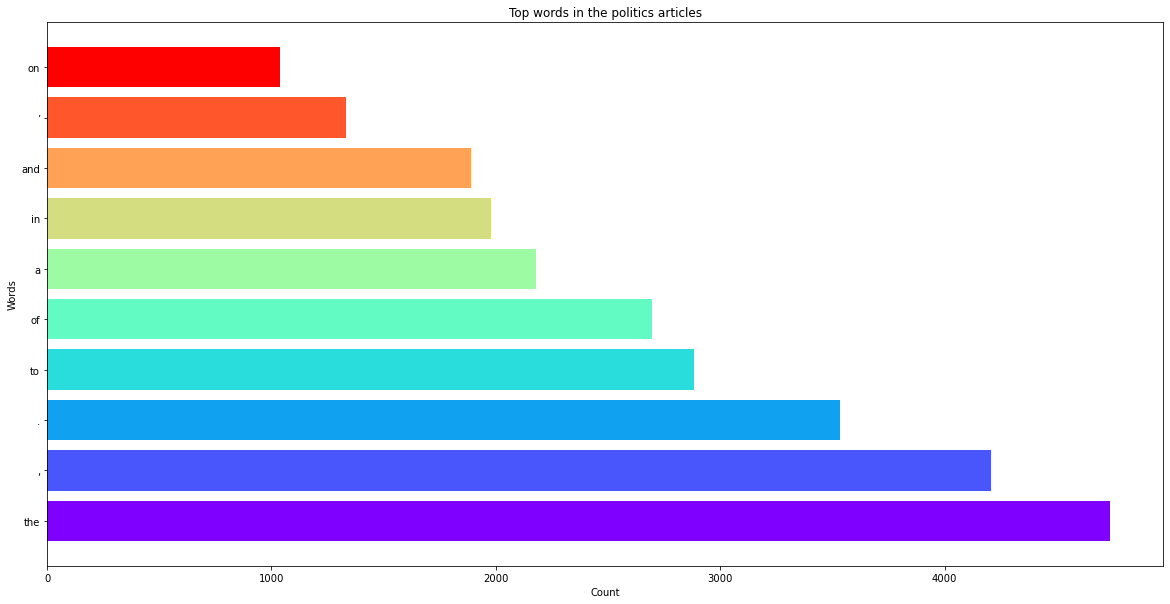

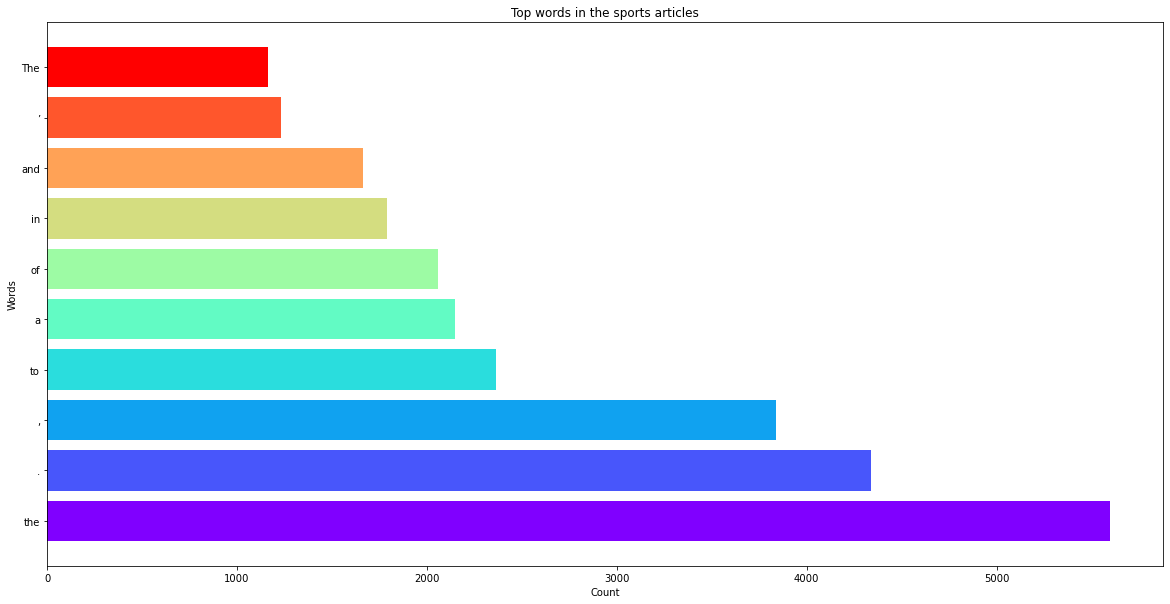

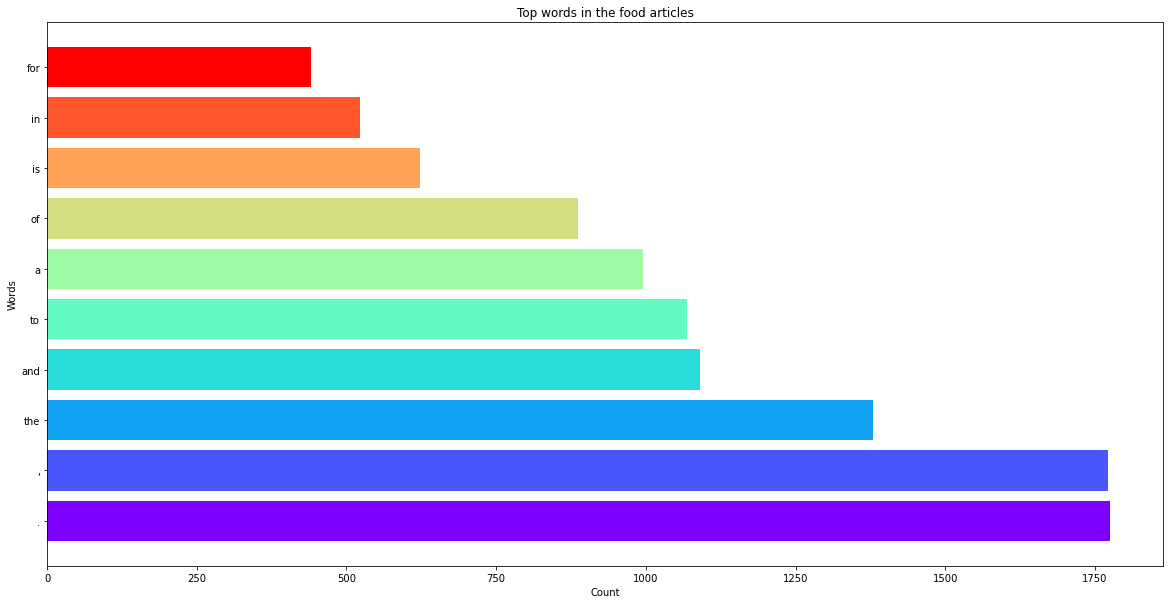

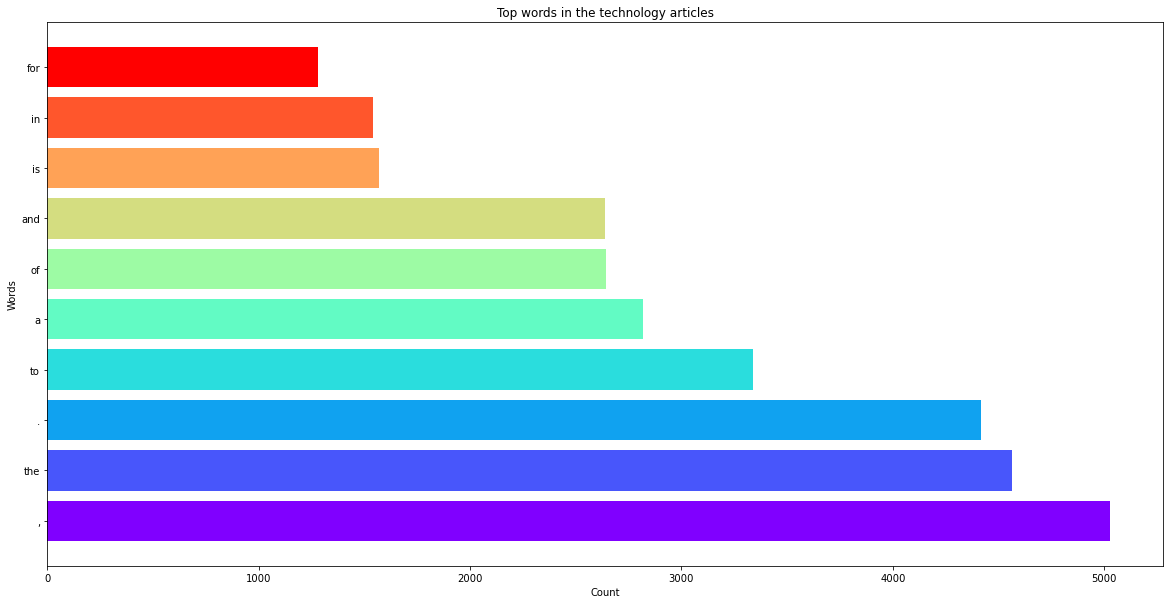

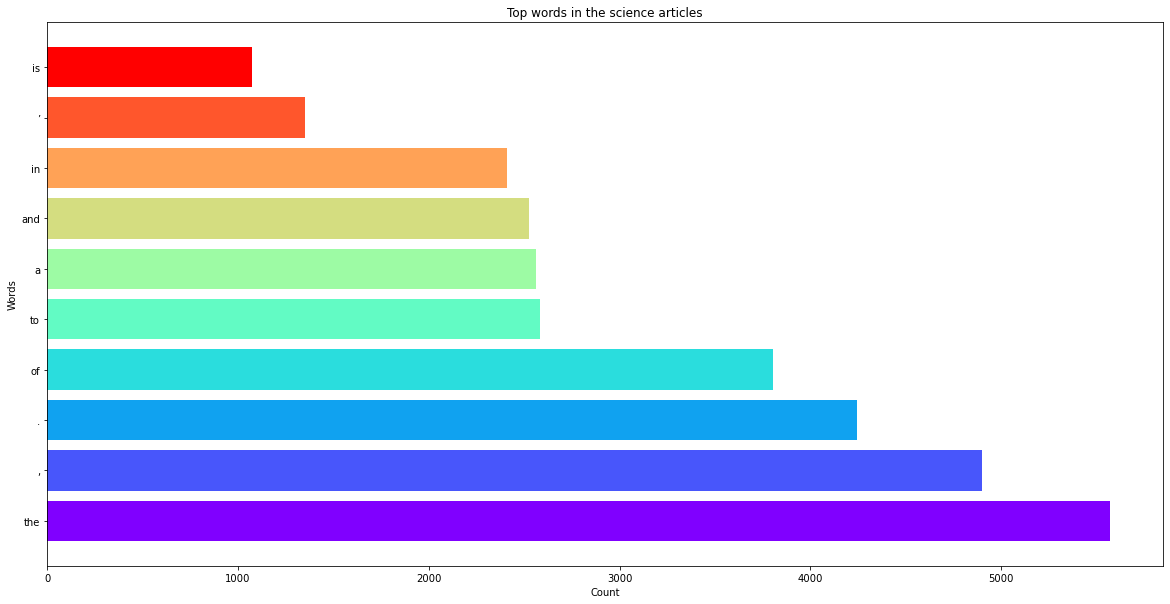

In [55]:
show_top_10_words(df)

### 5.2.4 Distribution of Words

In [56]:
def show_distribution_of_words(df):    
    tmp_df = df.copy()
    tmp_df["merged_text"] = tmp_df["merged_text"].apply(word_tokenize)
    tmp_df["words_count"] = tmp_df["merged_text"].apply(len)
    print(tmp_df.head())
    
    sns.set(rc={"figure.figsize": (10, 5)})
    ax = sns.distplot(tmp_df["words_count"], kde=False)
    plt.show()

  category                                        merged_text  words_count
0  weather  [Japan, Earthquake, :, JMA, Issues, Warning, f...           71
1  weather  [15, things, you, may, not, know, about, earth...           74
2  weather  ['Substantial, weather, pattern, change, ', br...           31
3  weather  [Tropics, watch, :, Forecasters, watching, one...           76
4  weather  [Hundreds, of, thousands, evacuated, in, China...           53


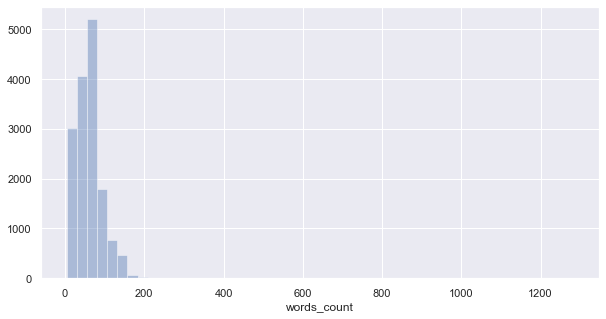

In [57]:
show_distribution_of_words(df)

### 5.2.5 Conclustion

## 5.3 Remove Text with Short Content

In [59]:
print(f"before: {df.shape}")
df = df[df["merged_text"].str.split().str.len().gt(7)]
print(f"after: {df.shape}")

before: (15385, 2)
after: (15385, 2)


## Banford's Law

{'1': 5367, '2': 7680, '3': 1651, '4': 1434, '5': 1560, '6': 1025, '7': 800, '8': 633, '9': 581}


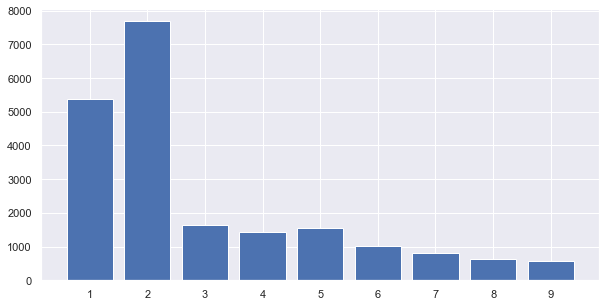

In [61]:
dict_nums = {'1':0 , '2':0, '3':0 , '4':0, '5':0 , '6':0, '7':0 , '8':0, '9':0}


numbers = []
for text in df['merged_text']:
    numbers = re.findall('[1-9]+', text)
    if (len(numbers) > 0):
        for num in numbers: 
            dict_nums[f'{num[0]}'] += 1

names = list(dict_nums.keys())
values = list(dict_nums.values())

print(dict_nums)
plt.bar(range(len(dict_nums)), values, tick_label=names)
plt.show()


## 5.4 Remove Numbers \n and \r from Text

In [62]:
# Remove numbers and \n \r - 
def remove_numbers_and_backslashes(column_name):
    for i, row in df.iterrows():    
        row[f"{column_name}"] = re.sub(r'\d','', row[f"{column_name}"])
        row[f"{column_name}"] = row[f"{column_name}"].replace("\n"," ")
        row[f"{column_name}"] = row[f"{column_name}"].replace("\r"," ")
        row[f"{column_name}"] = row[f"{column_name}"].replace("\t"," ")
        row[f"{column_name}"] = row[f"{column_name}"].replace("-"," ")


In [63]:
remove_numbers_and_backslashes("merged_text")

## 5.5 Remove non-english Texts


In [64]:
def remove_non_english_articles(df):
    for i, row in df.iterrows():
        try:
            # if en in detect_langs continue
            content_language = detect(row["merged_text"])
            if (row["category"] != "food") and (row["category"] != "entertainment") and (content_language != "en"):
                print("--------------------------------------")
                print(f"!!! Detect merged_text as {content_language} language.\nDrop row form df:\n{row}")
                print(detect_langs(row["merged_text"]))
                print("--------------------------------------")
                print()
                df.drop(i, inplace=True)

        except Exception as error:
            print(f"Drop row form df:\n {row}")
            df.drop(i, inplace=True) 

In [65]:
print(f"before: {df.shape}")
remove_non_english_articles(df)
print(f"after: {df.shape}")

before: (15385, 2)
--------------------------------------
!!! Detect merged_text as no language.
Drop row form df:
category                                              technology
merged_text    Top  Best Eyelid Tape () best eyelid tape for ...
Name: 404, dtype: object
[en:0.5714280123196938, no:0.4285698931797471]
--------------------------------------

--------------------------------------
!!! Detect merged_text as pt language.
Drop row form df:
category                                                 science
merged_text    Quem sou eu? Além da aspirante a poeta que já ...
Name: 830, dtype: object
[pt:0.999996057702211]
--------------------------------------

--------------------------------------
!!! Detect merged_text as es language.
Drop row form df:
category                                                business
merged_text    ¿Crees que sabes hablar con tus (potenciales) ...
Name: 1433, dtype: object
[es:0.9999946031689932]
--------------------------------------

-------------

## 5.6 Remove Special Characters

In [66]:
def remove_special_chars(text):
    pattern = r'[^A-Za-z0-9\s]+'
    return re.sub(pattern, '', text)

df['merged_text'] = df['merged_text'].apply(remove_special_chars)

## 5.7 Lemmatization and POS

In [67]:
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

In [68]:
def lemmatize_word(text):
    lemmatizer = WordNetLemmatizer()
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(text)) 
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatized_text = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_text.append(word)
        else:       
            lemmatized_text.append(lemmatizer.lemmatize(word, tag))
    lemmatized_text = " ".join(lemmatized_text)
    
    return lemmatized_text

In [69]:
print(df)
df['merged_text'] = df['merged_text'].apply(lemmatize_word)
print(df)

      category                                        merged_text
0      weather  Japan Earthquake JMA Issues Warning for More A...
1      weather   things you may not know about earthquakes Ear...
2      weather  Substantial weather pattern change bringing he...
3      weather  Tropics watch Forecasters watching one tropica...
4      weather  Hundreds of thousands evacuated in China after...
...        ...                                                ...
15408     food  Classic Tater Tot Casserole with Green Beans T...
15409     food  Stews of South India Know about different stew...
15410     food  Biscuits from Self Rising Flour Biscuits are a...
15411     food  Streusel Topping for Banana Bread for Example ...
15412     food   Fresh Summer Drinks That Refresh You If you a...

[15360 rows x 2 columns]
      category                                        merged_text
0      weather  Japan Earthquake JMA Issues Warning for More A...
1      weather  thing you may not know about earth

In [70]:
clean_df2 = df.copy()
clean_df2.reset_index(inplace=True)
clean_df2.to_csv("clean_df2.csv")

df = clean_df2.copy()


In [71]:
df.drop(columns="index", axis=1, inplace=True)
df.head()

,category,merged_text
0,weather,Japan Earthquake JMA Issues Warning for More A...
1,weather,thing you may not know about earthquake Earthq...
2,weather,Substantial weather pattern change bring heat ...
3,weather,Tropics watch Forecasters watch one tropical w...
4,weather,Hundreds of thousand evacuate in China after h...


## 5.8 Dataframe Lowercase

In [72]:
def convert_lower(text):
    text = text.lower()
    return text

df['merged_text'] = df['merged_text'].apply(convert_lower)
df

,category,merged_text
0,weather,japan earthquake jma issues warning for more a...
1,weather,thing you may not know about earthquake earthq...
2,weather,substantial weather pattern change bring heat ...
3,weather,tropics watch forecasters watch one tropical w...
4,weather,hundreds of thousand evacuate in china after h...
...,...,...
15355,food,classic tater tot casserole with green beans t...
15356,food,stews of south india know about different stew...
15357,food,biscuits from self rising flour biscuits be a ...
15358,food,streusel topping for banana bread for example ...


## 5.9 Remove Stopwords

In [77]:
stop_words = stopwords.words('english') + ["a","this", "one", "new", "say", "may", "get", "make", "use", "i", "the","first"]
df['merged_text'] = df['merged_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


## 5.10 Visualization Vol.2

### 5.10.1 Pie Chart

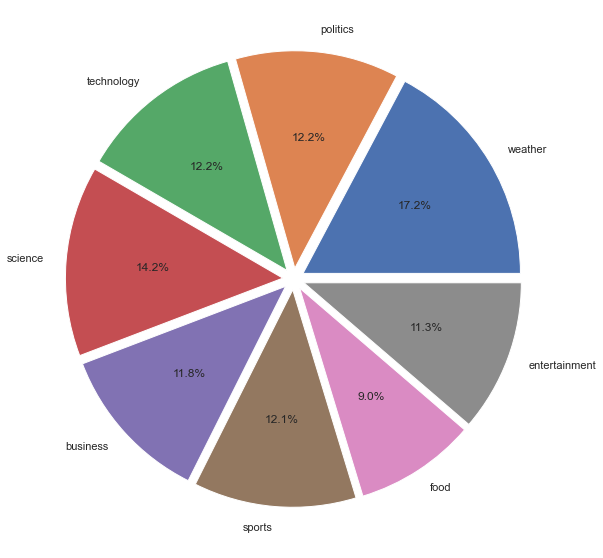

In [78]:
show_pie_chart(df)

### 5.10.2 WordCloud

/Users/sergeyjuchenko/Desktop/HIT.DataScience.FinalProject-main/png/entertainment.png


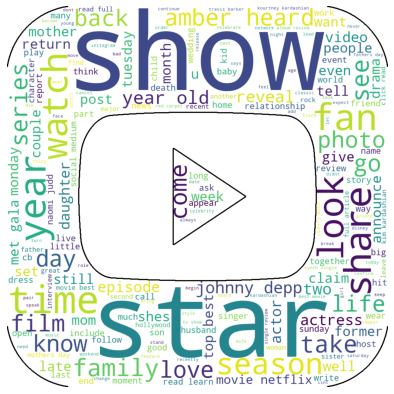

/Users/sergeyjuchenko/Desktop/HIT.DataScience.FinalProject-main/png/weather.png


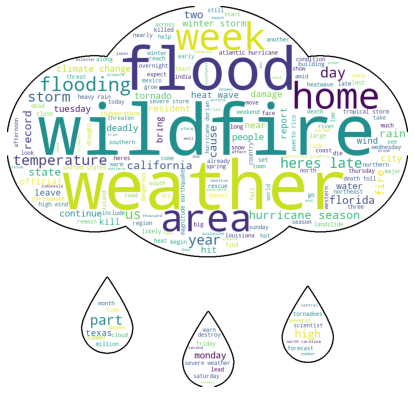

/Users/sergeyjuchenko/Desktop/HIT.DataScience.FinalProject-main/png/business.png


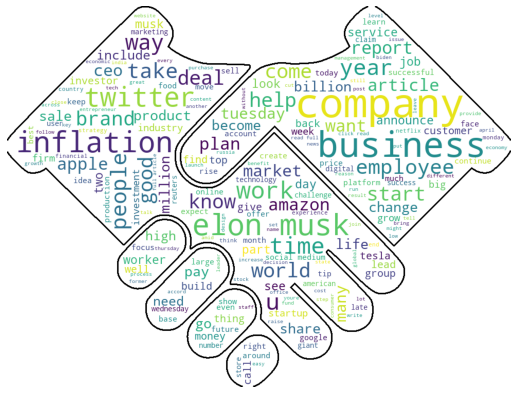

/Users/sergeyjuchenko/Desktop/HIT.DataScience.FinalProject-main/png/politics.png


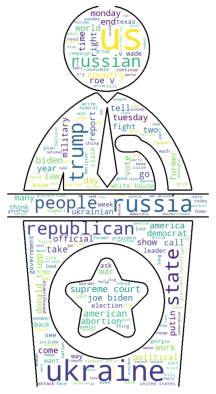

/Users/sergeyjuchenko/Desktop/HIT.DataScience.FinalProject-main/png/sports.png


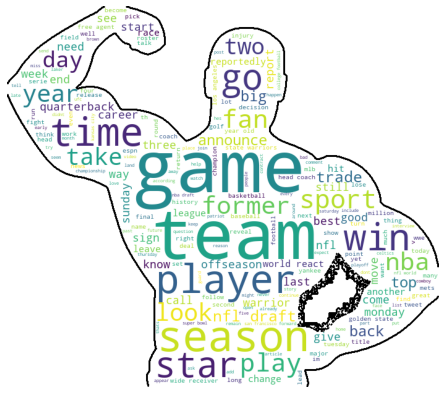

/Users/sergeyjuchenko/Desktop/HIT.DataScience.FinalProject-main/png/food.png


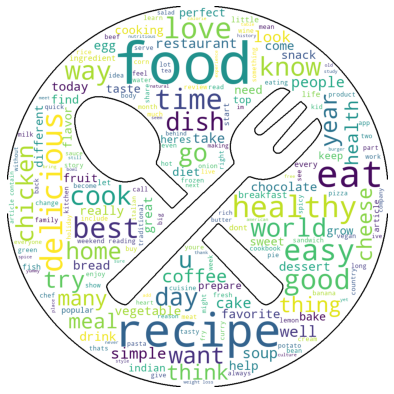

/Users/sergeyjuchenko/Desktop/HIT.DataScience.FinalProject-main/png/technology.png


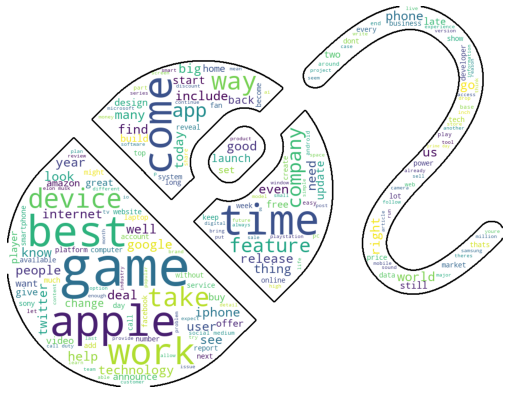

/Users/sergeyjuchenko/Desktop/HIT.DataScience.FinalProject-main/png/science.png


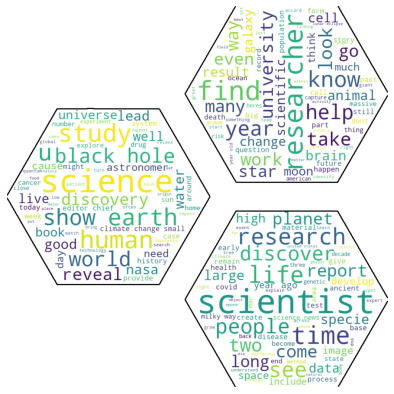

In [79]:
show_word_cloud(df)

### 5.10.3 Top 10 Words

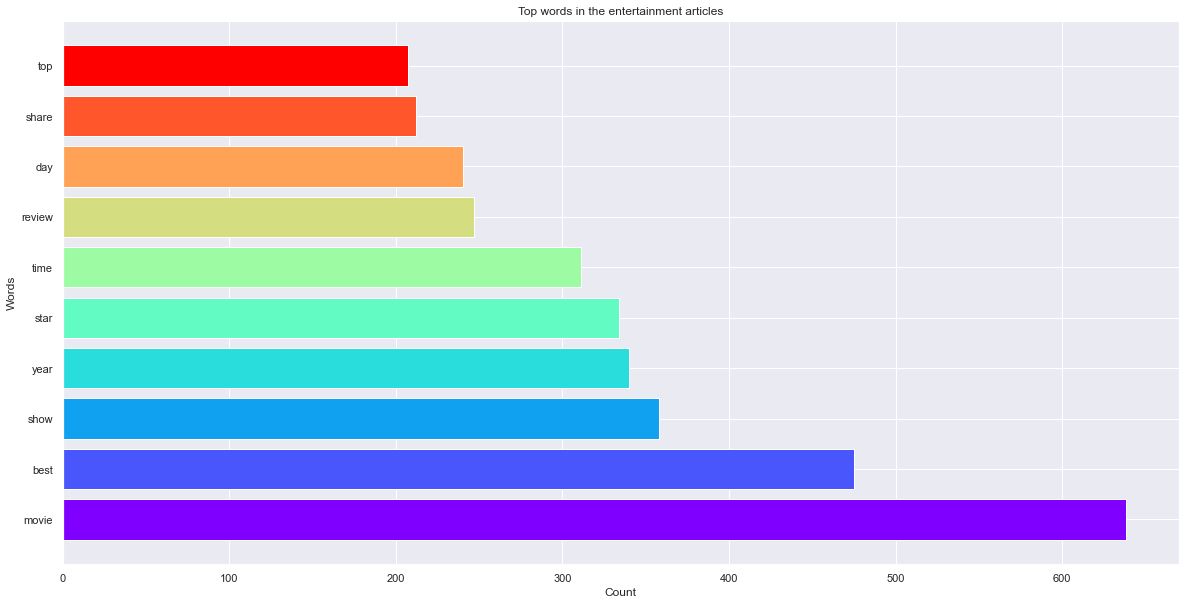

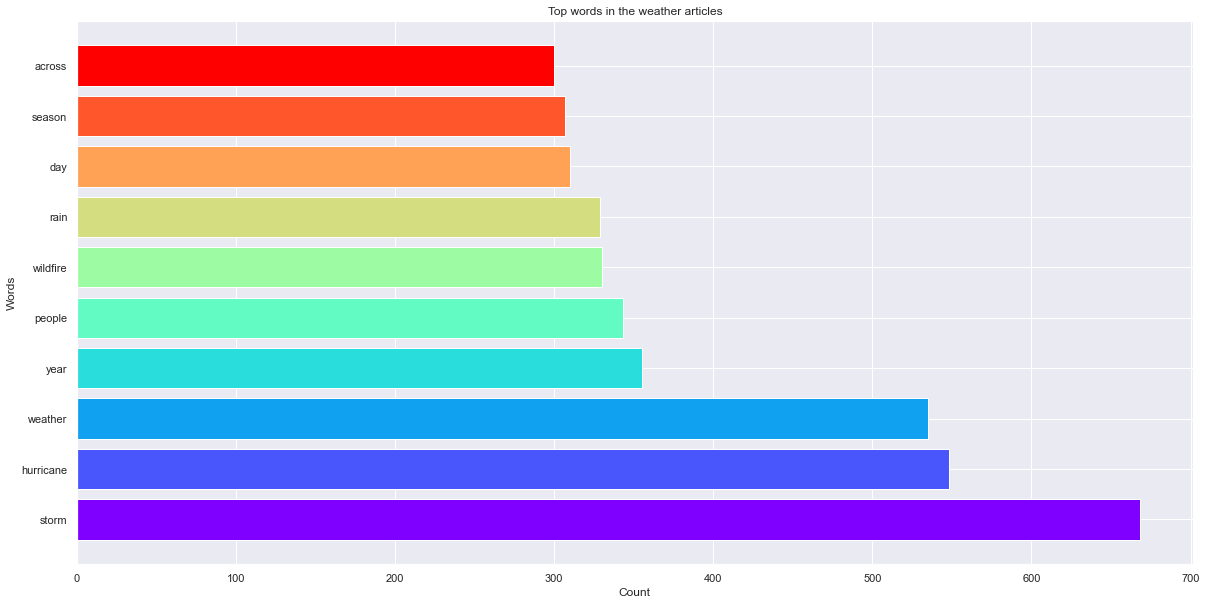

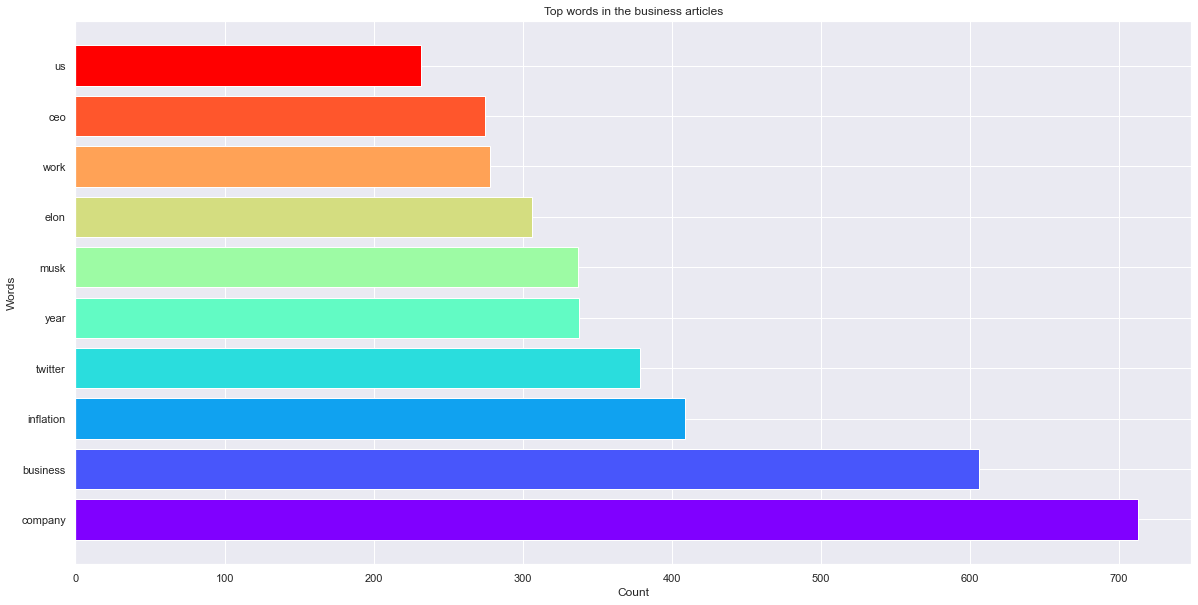

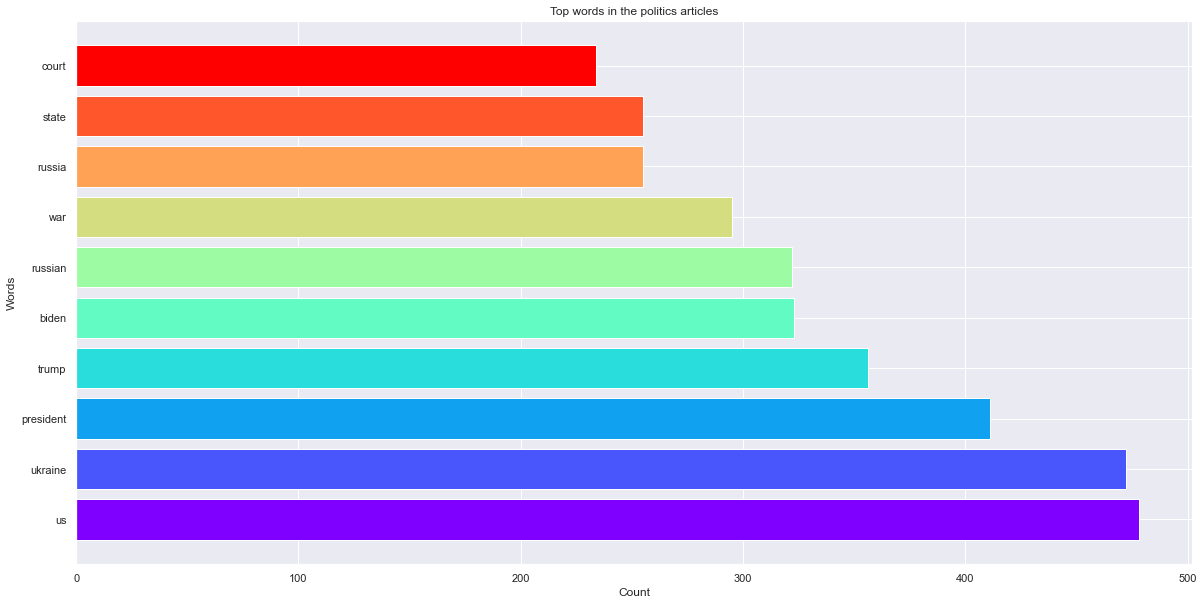

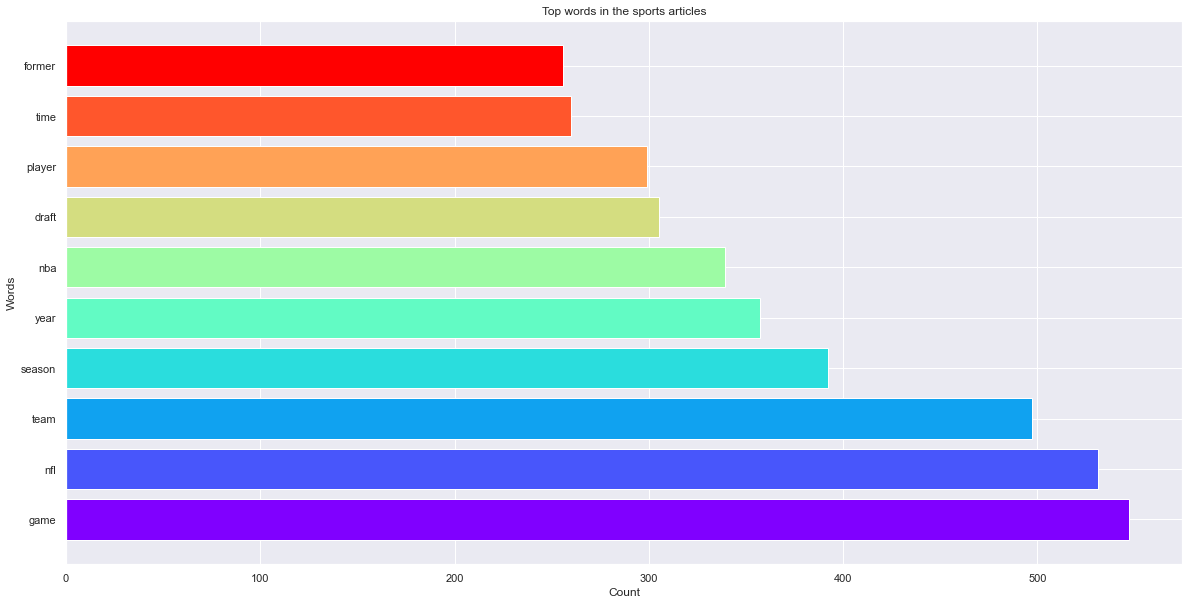

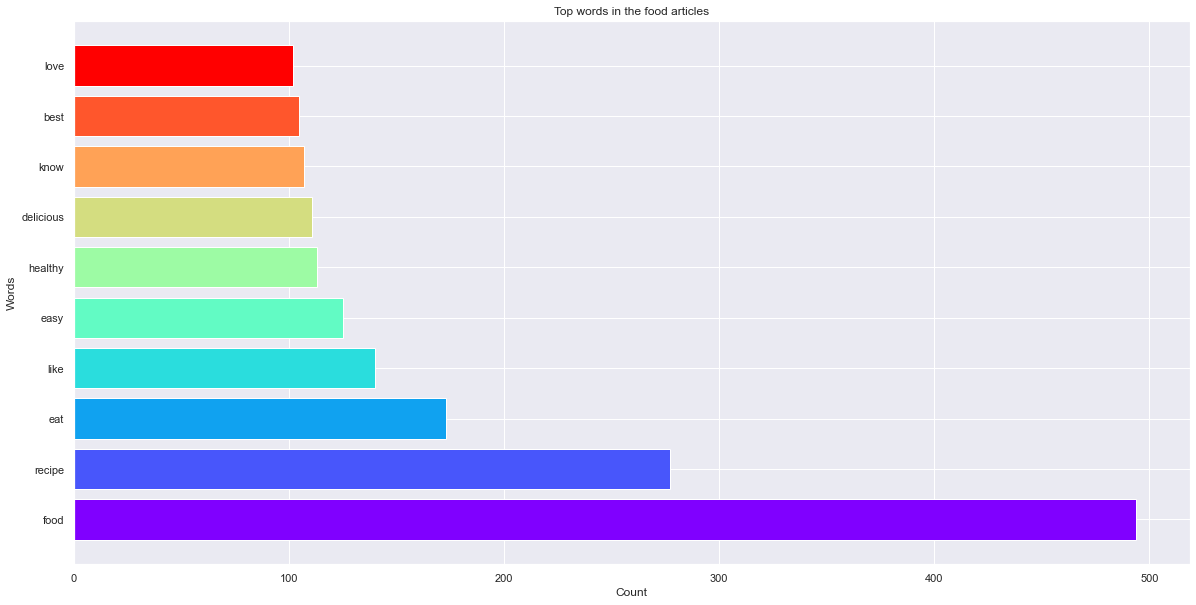

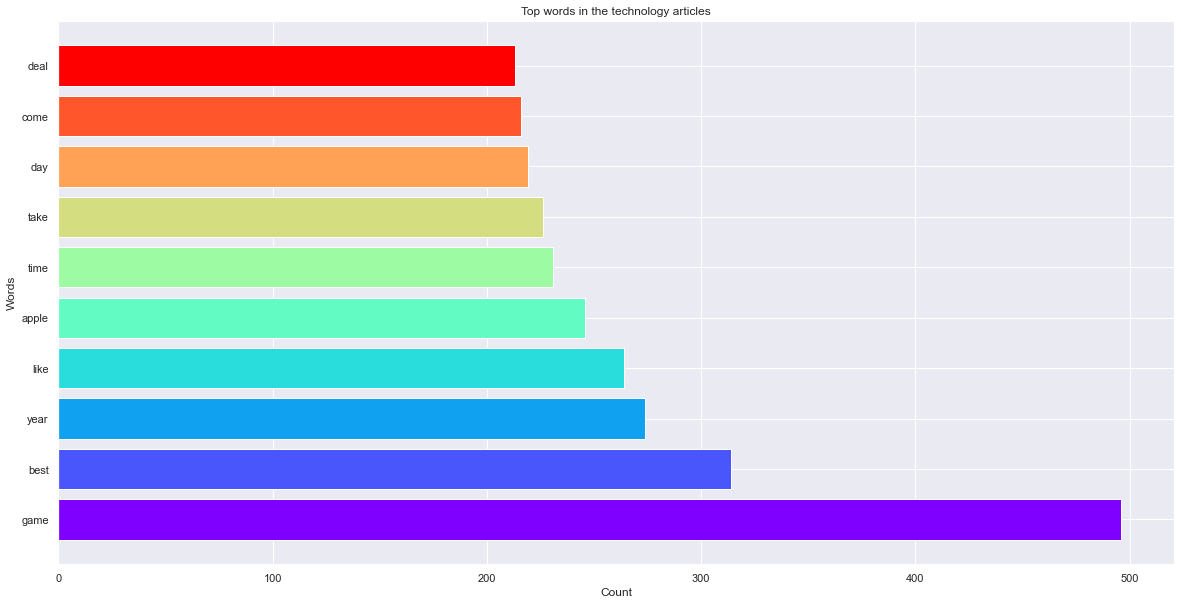

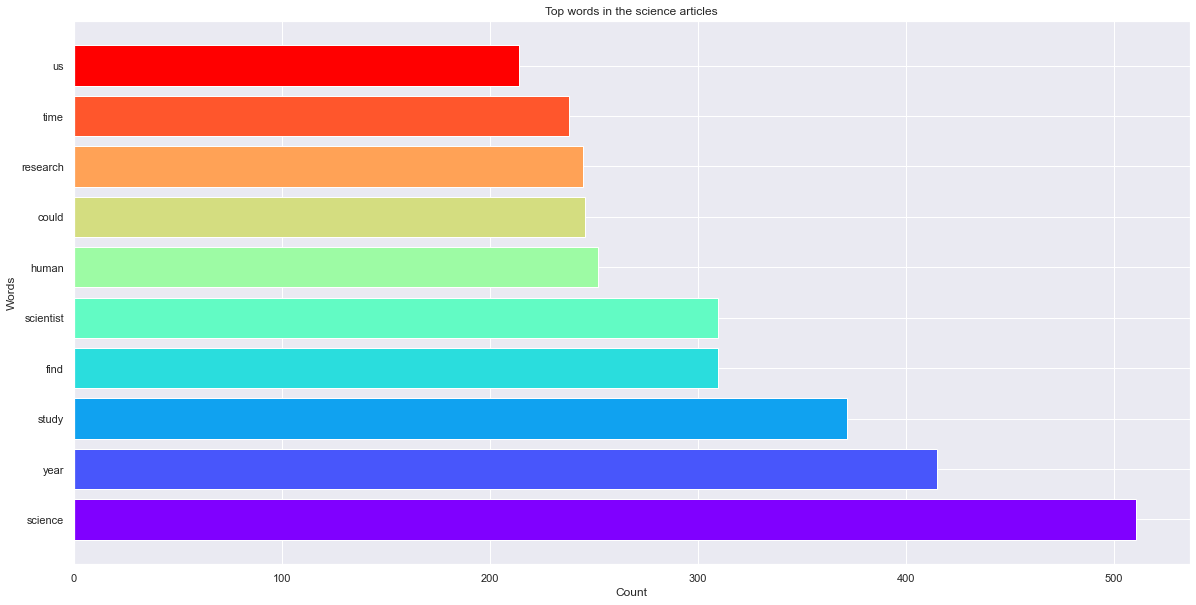

In [80]:
show_top_10_words(df)

### 5.10.4 Distribution of Words

  category                                        merged_text  words_count
0  weather  [japan, earthquake, jma, issues, warning, afte...           40
1  weather  [thing, know, earthquake, earthquakes, small, ...           30
2  weather  [substantial, weather, pattern, change, bring,...           18
3  weather  [tropics, watch, forecasters, watch, tropical,...           44
4  weather  [hundreds, thousand, evacuate, china, heavy, r...           31


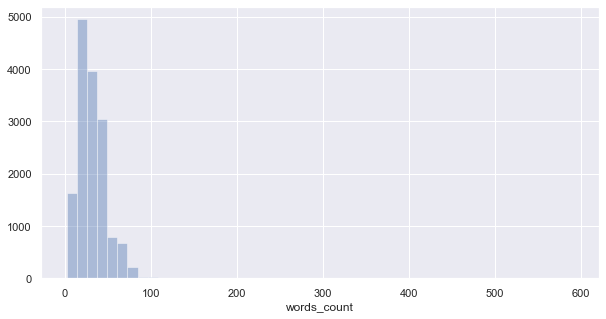

In [81]:
show_distribution_of_words(df)

In [224]:
df.to_csv("ml_data.csv")
ml_df = df.copy()

### 5.10.5 Conclustion

## 5.11 Final EDA Conclustion

# 6.0 Vectorization and Machine Learning

In [225]:
ml_df.head()

,category,merged_text
0,weather,japan earthquake jma issues warning aftershock...
1,weather,thing know earthquake earthquakes small never ...
2,weather,substantial weather pattern change bring heat ...
3,weather,tropics watch forecasters watch tropical wave ...
4,weather,hundreds thousand evacuate china heavy rain de...


In [226]:
x = np.array(ml_df["merged_text"])
y = np.array(ml_df["category"])

cnt_vectorizer = CountVectorizer(min_df=2)
x = cnt_vectorizer.fit_transform(x)

In [227]:
# print(cnt_vectorizer.vocabulary_)

In [228]:
print(f"feutures:{len(cnt_vectorizer.get_feature_names())}")
print(f"x shape: {x.shape}") #text vector
print(f"y shape: {y.shape}") #category  

feutures:18218
x shape: (15360, 18218)
y shape: (15360,)


In [229]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42)

model = MultinomialNB()
model.fit(x_train,y_train) 

MultinomialNB()

## Confusion Matrix

accuracy: 0.8266059027777778


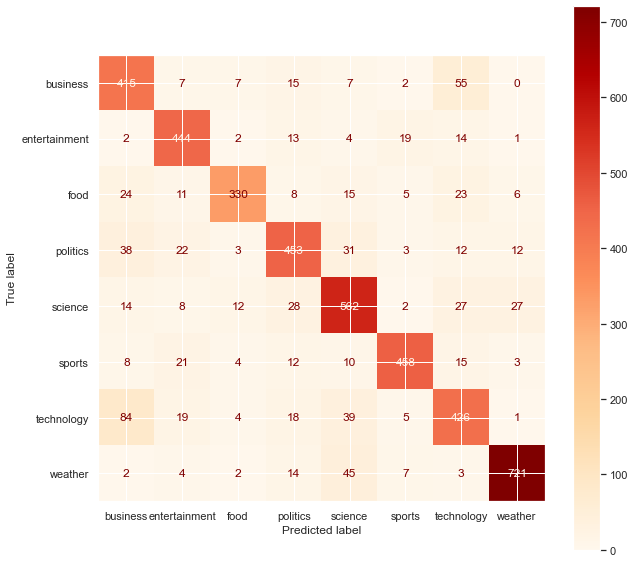

In [230]:
predicted = model.predict(x_test)
print(f"accuracy: {np.mean(predicted == y_test)}")

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(model, x_test, y_test,cmap="OrRd",ax=ax)

In [231]:
print(metrics.classification_report(y_test, predicted,target_names=set(y_test)))

               precision    recall  f1-score   support

entertainment       0.71      0.82      0.76       508
      weather       0.83      0.89      0.86       499
     business       0.91      0.78      0.84       422
         food       0.81      0.79      0.80       574
       sports       0.79      0.83      0.81       680
     politics       0.91      0.86      0.89       531
   technology       0.74      0.71      0.73       596
      science       0.94      0.90      0.92       798

     accuracy                           0.83      4608
    macro avg       0.83      0.82      0.82      4608
 weighted avg       0.83      0.83      0.83      4608



## 6.1 Cross Validation
Stratified K-Fold is an enhanced version of K-Fold cross-validation which is mainly used for imbalanced datasets. Just like K-fold, the whole dataset is divided into K-folds of equal size.

But in this technique, each fold will have the same ratio of instances of target variable as in the whole datasets.

In [232]:
stratifiedkf=StratifiedKFold(n_splits=20)
score=cross_val_score(m_nb,x,y,cv=stratifiedkf)
print(f"Cross Validation Scores are {score}")
print(f"Average Cross Validation score :{score.mean()}")

Cross Validation Scores are [0.82682292 0.84375    0.84114583 0.83984375 0.85677083 0.82161458
 0.81901042 0.81901042 0.77213542 0.76953125 0.79166667 0.75651042
 0.828125   0.85026042 0.84635417 0.80989583 0.86197917 0.859375
 0.8359375  0.8046875 ]
Average Cross Validation score :0.8227213541666666


In [233]:
text_to_predict = "avi is the best researcher in israel"
text_to_predict = cnt_vectorizer.transform([text_to_predict]).toarray()

In [234]:
print(model.predict(text_to_predict))

['science']


## Random Forest Classifier

In [235]:
model = RandomForestClassifier(max_depth=60000)
model.fit(x_train,y_train)


RandomForestClassifier(max_depth=60000)

accuracy: 0.7610677083333334


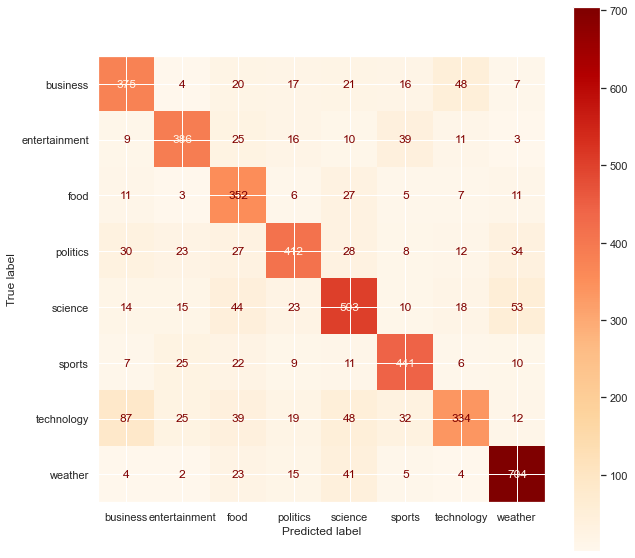

In [236]:
predicted = model.predict(x_test)
print(f"accuracy: {np.mean(predicted == y_test)}")

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(model, x_test, y_test,cmap="OrRd",ax=ax)

In [237]:
text_to_predict = "avi is the best researcher in israel"
text_to_predict = cnt_vectorizer.transform([text_to_predict]).toarray()
print(model.predict(text_to_predict))

['science']


# 7.0 Project Conclustion